# Imports

In [44]:
import sys
import numpy as np

In [45]:
from src.convolution.numerical import function_norm, convolution_integrand, convolution
from src.helpers import bin_edges, binning_type, first_moment

In [46]:
# plotting
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

In [47]:
!python -V

Python 3.11.4


# Step function

In [48]:
from src.convolution.numerical import step_function, step_functions

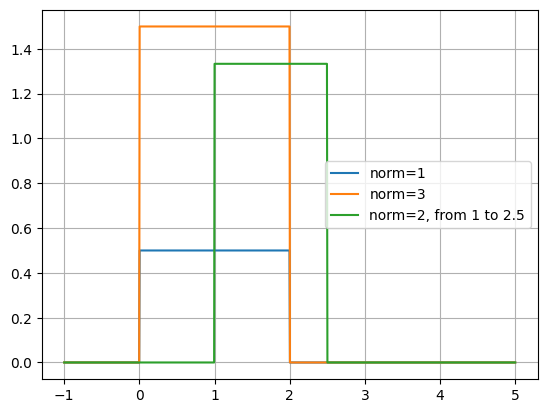

In [49]:
xvalues = np.linspace(start=-1, stop=5, num=1000)
fig, ax = plt.subplots()
ax.plot(xvalues, step_functions(xvalues), label="norm=1")
ax.plot(xvalues, step_functions(xvalues, norm=3), label="norm=3")
ax.plot(xvalues, step_functions(xvalues, lower=1, upper=2.5, norm=2), label="norm=2, from 1 to 2.5")
ax.grid()
ax.legend();

## Norm

In [50]:
function_norm(step_function, lower_limit=-1, upper_limit=3)

1.0

In [51]:
# check if norm can be calculated by indefinite integral (no integration limits, means integral from -inf to inf)
function_norm(step_function)

0.9999999999999855

In [52]:
# check if function with other norm is normalized as well
function_norm(step_function, lower_limit=-1, upper_limit=3, args=(5,))

5.0

## Convolution

## Integrand function

In [53]:
# check single value of convolution integrand
convolution_integrand(step_function)(t=1, y=1.5)

0.25

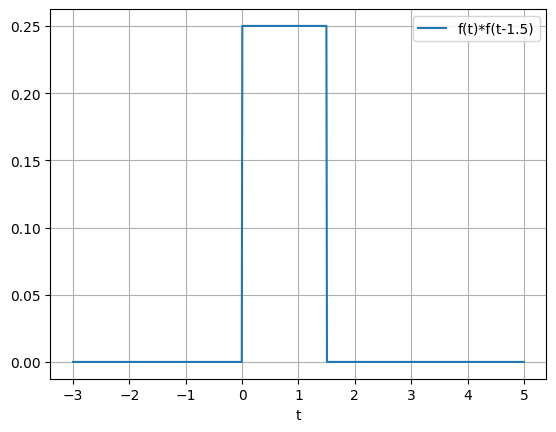

In [54]:
# plot convolution integrand for given y
y = 1.5
t_values = np.linspace(start=-3, stop=5, num=800)
integrand_values_for_given_y = np.array([convolution_integrand(step_function)(t=t, y=y) for t in t_values])
fig, ax = plt.subplots()
ax.plot(t_values, integrand_values_for_given_y, label=f"f(t)*f(t-{y})")
ax.grid()
ax.set_xlabel("t")
ax.legend();

In [55]:
# check convolution integrand for some other parameters
convolution_integrand(step_function)(t=0, y=0, kwargs={'norm': 5, 'lower': -0.5, 'upper': 0.5})

25.0

## Issues with integration procedure

In [56]:
# by default step function domain is [0,2], here we will focus on the interval [-0.5,0.5]
# we expect that convolution will have triangular shape on a domain [-1, 1]
step_function_args = (1,-0.5,0.5,0)

/home/grzanka/workspace/widma/src/convolution/numerical.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(func=integrand, a=lower_limit, b=upper_limit, args=(y, integrand_args), *args, **kwargs)


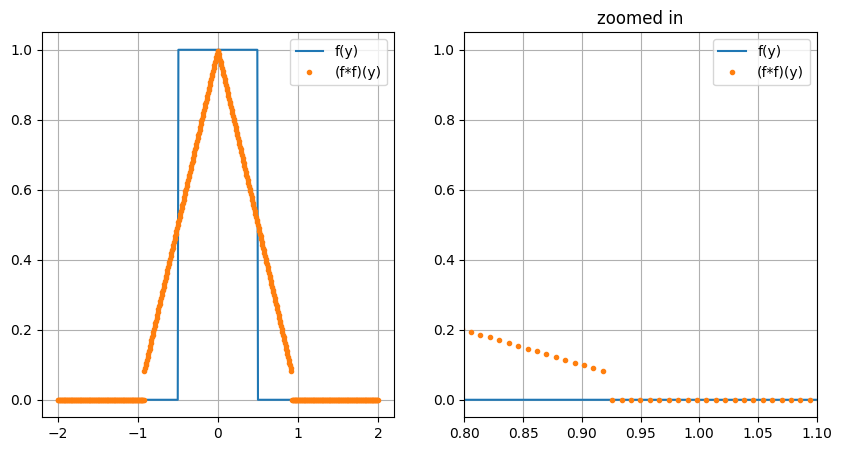

In [57]:
# plotting limits
y_values = np.linspace(start=-2, stop=2, num=500)
# lets try default integration settings, meaning indefinite integral (from -inf to inf)
convolution_values_default = np.array([convolution(step_function)(y=y, integrand_args=step_function_args)[0] for y in y_values])

#plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for a in ax:
    a.plot(y_values, step_functions(y_values, *step_function_args), label="f(y)")
    a.plot(y_values, convolution_values_default, '.', label="(f*f)(y)")
    a.grid()
    a.legend();
ax[1].set_xlim([0.8,1.1]);
ax[1].set_title("zoomed in");

In [58]:
# I'd expect that for y > 0 (f*f)(y) = 1 - y which means that (f*f)(0.95) = 1.05
# from the plot above we can see that (f*f)(0.95) = 0, morevoer (f*f)(0.95) = 0 for any y > 0.93
# here we calculate the same integral in on point
y = 0.95
c, abserr = convolution(step_function)(y=y, integrand_args=step_function_args)
c, abserr

(0.0, 0.0)

In [59]:
# to get correct value we add several modifications to the integration routine
#  - we adjust the integration limits to twice the expected domain
#  - we add more integration nodes to cover the expected domain
#  - we increase the limit of integration steps from default 50 to 2000 (needs do be larger than number of nodes)
y = 0.95

# definition of the step function
step_function_args = (1,-0.5,0.5,0)

# add more points to the integral covering the expected domain
expected_conv_domain = (-1,1)
integral_kwargs = {'limit': 2000, 'points': np.linspace(*expected_conv_domain,100)}

# integrate the step function over explicit domain
convolution_integration_limits = (2*expected_conv_domain[0], 2*expected_conv_domain[1])

c, abserr = convolution(
    step_function, 
    lower_limit=convolution_integration_limits[0],
    upper_limit=convolution_integration_limits[1],
    kwargs=integral_kwargs)(y=y, integrand_args=step_function_args)
print(f"(f*f)({y}) = {c}, absolute error: {abserr}")

(f*f)(0.95) = 0.050000000000000086, absolute error: 5.551115123125793e-17


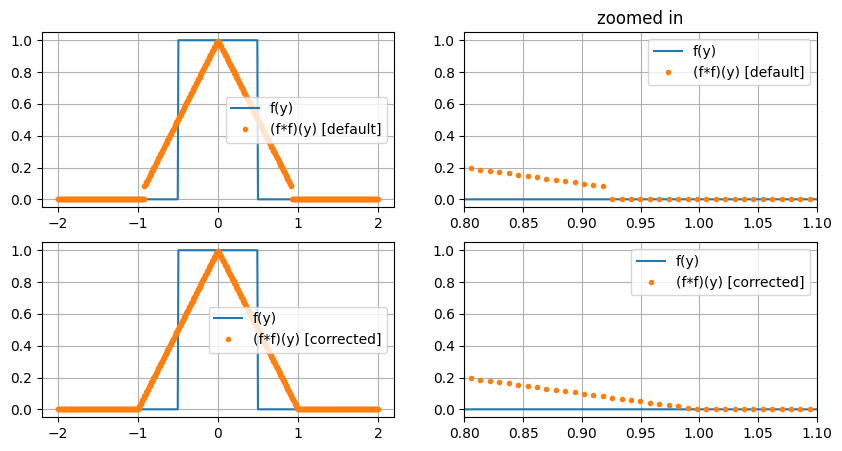

In [60]:
# plotting limits
y_values = np.linspace(start=-2, stop=2, num=500)

# definition of the step function
step_function_args = (1,-0.5,0.5,0)

# add more points to the integral covering the expected domain
expected_conv_domain = (-1,1)
integral_kwargs = {'limit': 2000, 'points': np.linspace(*expected_conv_domain,100)}

# integrate the step function over explicit domain
convolution_integration_limits = (2*expected_conv_domain[0], 2*expected_conv_domain[1])

convolution_values_corrected = np.array([convolution(step_function, 
    lower_limit=convolution_integration_limits[0],
    upper_limit=convolution_integration_limits[1],
    kwargs=integral_kwargs)(y=y, integrand_args=step_function_args)[0] for y in y_values])

#plotting
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
for a in ax.flatten():
    a.plot(y_values, step_functions(y_values, *step_function_args), label="f(y)")
for a in ax.T:
    a[0].plot(y_values, convolution_values_default, '.', label="(f*f)(y) [default]")
    a[1].plot(y_values, convolution_values_corrected, '.', label="(f*f)(y) [corrected]")
for a in ax:
    a[1].set_xlim([0.8,1.1]);
for a in ax.flatten():
    a.grid()
    a.legend();
ax[0][1].set_title("zoomed in");


## First moments

f1_1st_moment=1.00, f2_1st_moment=2.00


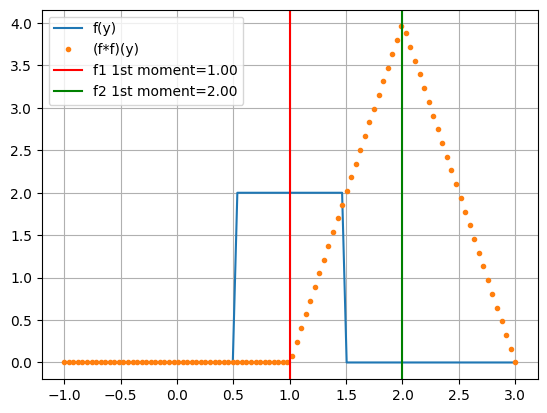

In [61]:
# plotting limits
y_values = np.linspace(start=-1, stop=3, num=100)

# definition of the step function
step_function_args = (2,0.5,1.5,0)

# integration settings
integral_kwargs = {'limit': 2000, 'points': np.linspace(0,3,100)}
convolution_integration_limits = (0, 4)
convolution_values = np.array([convolution(
    step_function,
    lower_limit=convolution_integration_limits[0], 
    upper_limit=convolution_integration_limits[1], 
    kwargs=integral_kwargs)(y=y, integrand_args=step_function_args)[0] for y in y_values])

from src.helpers import first_moment
edges = bin_edges(bin_centers=y_values, binning_type=binning_type(bin_centers=y_values))
f1_1st_moment = first_moment(bin_edges=edges, bin_values=step_functions(y_values, *step_function_args))
f2_1st_moment = first_moment(bin_edges=edges, bin_values=convolution_values)
print(f"f1_1st_moment={f1_1st_moment:2.2f}, f2_1st_moment={f2_1st_moment:2.2f}")

#plotting
fig, ax = plt.subplots()
ax.plot(y_values, step_functions(y_values, *step_function_args), label="f(y)")
ax.plot(y_values, convolution_values, '.', label="(f*f)(y)")
ax.axvline(f1_1st_moment, color='r', label=f"f1 1st moment={f1_1st_moment:2.2f}")
ax.axvline(f2_1st_moment, color='g', label=f"f2 1st moment={f2_1st_moment:2.2f}")
ax.grid();
ax.legend();

# Spectrum

## Data

In [62]:
from src.spectrum import SpectrumData, from_csv, SpectrumValueType
from src.paths import project_dir

In [63]:
# lets load spectrum from csv file
spectrum = from_csv(project_dir / 'data' / 'interim' / 'data.csv', delimiter=',', value_type=SpectrumValueType.yfy)
spectrum.norm

0.9938634018608192

In [64]:
# due to digitization we have to adjust the spectrum as negative values are not allowed
spectrum.yfy.min(), spectrum.yfy.max()

(-0.0008956877263814889, 0.4982137261046694)

In [65]:
# lets replace the negative values with 0
spectrum_clipped = SpectrumData(bin_centers=spectrum.bin_centers, bin_values_yfy=spectrum.yfy.clip(min=0))
spectrum_clipped.yfy.min(), spectrum_clipped.yfy.max()

(0.0, 0.4982137261046694)

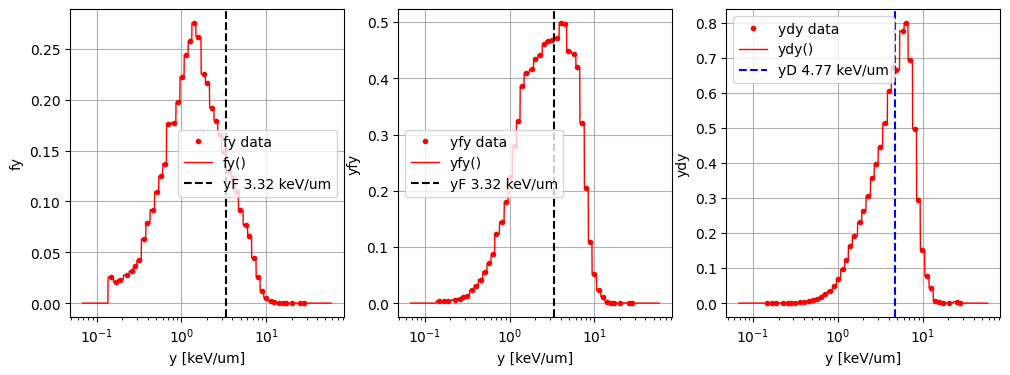

In [66]:
xvalues = np.geomspace(start=spectrum_clipped.bin_edges[0]/2, stop=spectrum_clipped.bin_edges[-1]*2, num=1000)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, '.', label='fy data', color='r')
ax[0].plot(xvalues, spectrum_clipped.bin_values(xvalues, spectrum_value_type=SpectrumValueType.fy), label='fy()', linestyle='-', linewidth=1, color='r')
ax[0].axvline(spectrum_clipped.yF, color='k', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[0].set_ylabel('fy')
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, '.', label='yfy data', color='r')
ax[1].plot(xvalues, spectrum_clipped.bin_values(xvalues, spectrum_value_type=SpectrumValueType.yfy), label='yfy()', linestyle='-', linewidth=1, color='r')
ax[1].axvline(spectrum_clipped.yF, color='k', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[1].set_ylabel('yfy')
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, '.', label='ydy data', color='r')
ax[2].plot(xvalues, spectrum_clipped.bin_values(xvalues, spectrum_value_type=SpectrumValueType.ydy), label='ydy()', linestyle='-', linewidth=1, color='r')
ax[2].axvline(spectrum_clipped.yD, color='b', linestyle='--', label=f'yD {spectrum_clipped.yD:2.2f} keV/um')
ax[2].set_ylabel('ydy')
for a in ax:
    a.set_xscale('log')
    a.grid()
    a.set_xlabel('y [keV/um]')
    a.legend()

## Normalization

In [67]:
pdf_function = lambda x : spectrum_clipped.bin_value(x, spectrum_value_type=SpectrumValueType.fy) 
function_norm(pdf_function, lower_limit=spectrum_clipped.bin_edges[0], upper_limit=spectrum_clipped.bin_edges[-1])

/home/grzanka/workspace/widma/src/convolution/numerical.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(func=func, a=lower_limit, b=upper_limit, args=args)


0.9870827697855141

In [68]:
pdf_function = lambda x : spectrum_clipped.bin_value(x, spectrum_value_type=SpectrumValueType.fy)
function_norm(pdf_function)

0.9937516998520008

In [69]:
function_norm(spectrum_clipped.bin_value, args=(SpectrumValueType.fy,))

0.9937516998520008

## Folding

### Single values

In [70]:
# we apply convolution on f(y), not on yfy or ydy
f1_function = lambda x : spectrum_clipped.bin_value(x, spectrum_value_type=SpectrumValueType.fy) 
f1_function(2)

0.21672449170916908

In [71]:
# lets calculate single value of f2 function (convolution of f1 with itself)
convolution(
    f1_function,
    lower_limit=spectrum_clipped.bin_edges[0]/2, 
    upper_limit=spectrum_clipped.bin_edges[-1]*2, 
    kwargs=integral_kwargs)(4)

(0.1199809086812579, 7.509389998716642e-09)

### Domain and plotting

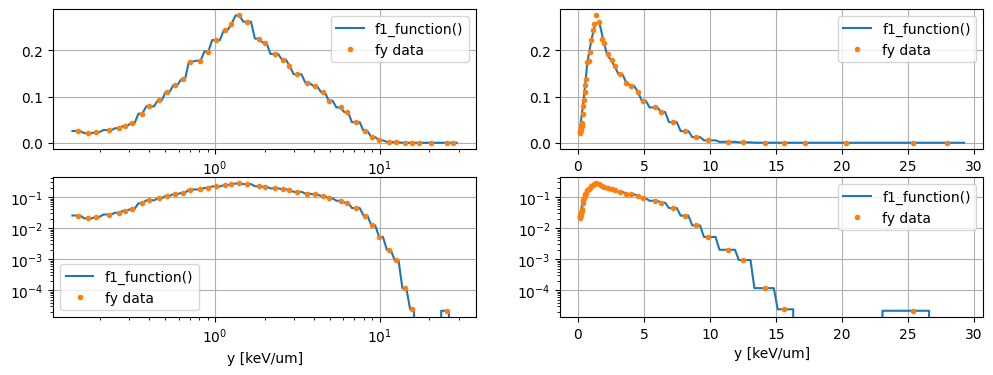

In [72]:
# lets inspect f1 function on various scales
xvalues_geom = np.geomspace(start=spectrum_clipped.bin_edges[0], stop=spectrum_clipped.bin_edges[-1], num=100)
xvalues_lin = np.linspace(start=spectrum_clipped.bin_edges[0], stop=spectrum_clipped.bin_edges[-1], num=100)
yvalues_geom = f1_function(xvalues_geom)
yvalues_lin = f1_function(xvalues_lin)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
ax[0][0].plot(xvalues_geom, yvalues_geom, label='f1_function()')
ax[0][0].set_xscale('log')
ax[0][1].plot(xvalues_lin, yvalues_lin, label='f1_function()')
ax[1][0].plot(xvalues_geom, yvalues_geom, label='f1_function()')
ax[1][0].set_xscale('log')
ax[1][0].set_yscale('log')
ax[1][1].plot(xvalues_lin, yvalues_lin, label='f1_function()')
ax[1][1].set_yscale('log')
for a in ax.flatten():
    a.plot(spectrum_clipped.y, spectrum_clipped.fy, '.', label='fy data')
    a.grid()
    a.set_xlabel('y [keV/um]')
    a.legend()

In [73]:
expected_f2_domain = (spectrum_clipped.bin_edges[0]*2,spectrum_clipped.bin_edges[-1]*2.)
xvalues_for_f2 = np.geomspace(start=expected_f2_domain[0], stop=expected_f2_domain[1], num=50)

convolution_integration_limits = (spectrum_clipped.bin_edges[0]/2,spectrum_clipped.bin_edges[-1]*2)
integral_kwargs = {'limit': 800, 'points': np.geomspace(*convolution_integration_limits,400)}
f2_values_and_errors = [convolution(
    f1_function,
    lower_limit=convolution_integration_limits[0], 
    upper_limit=convolution_integration_limits[1], 
    kwargs=integral_kwargs)(y) for y in xvalues_for_f2]

/home/grzanka/workspace/widma/src/convolution/numerical.py:36: IntegrationWarning: The maximum number of subdivisions (800) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(func=integrand, a=lower_limit, b=upper_limit, args=(y, integrand_args), *args, **kwargs)


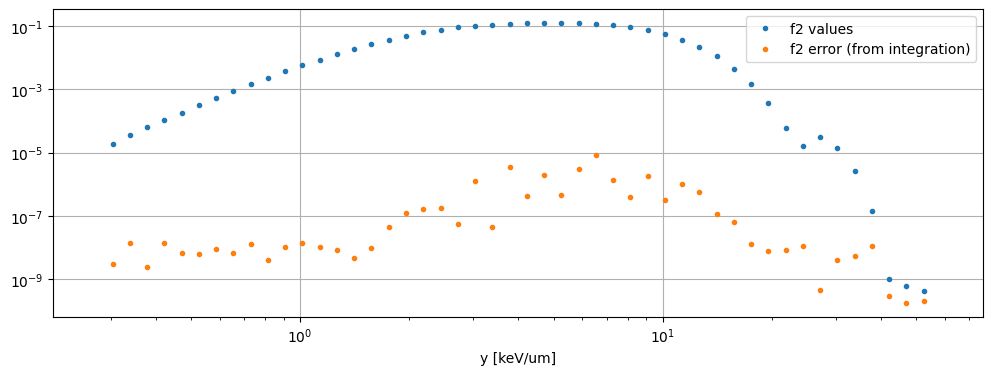

In [74]:
# by comparing the integration error with f2 values we check the numerical integration accuracy
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(xvalues_for_f2, [item[0] for item in f2_values_and_errors], '.', label='f2 values')
ax.plot(xvalues_for_f2, [item[1] for item in f2_values_and_errors], '.', label='f2 error (from integration)')
ax.grid()
ax.set_xlabel('y [keV/um]')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

In [75]:
f2_spectrum = SpectrumData(bin_centers=xvalues_for_f2, bin_values_fy=np.array([item[0] for item in f2_values_and_errors]))

In [76]:
f2_spectrum.yF, f2_spectrum.yD

(6.654154427498713, 8.115532443525396)

In [77]:
# check if yF is doubled
f2_spectrum.yF / spectrum_clipped.yF

2.0034668873852466

In [78]:
# check norm
f2_spectrum.norm

0.9889273413145863

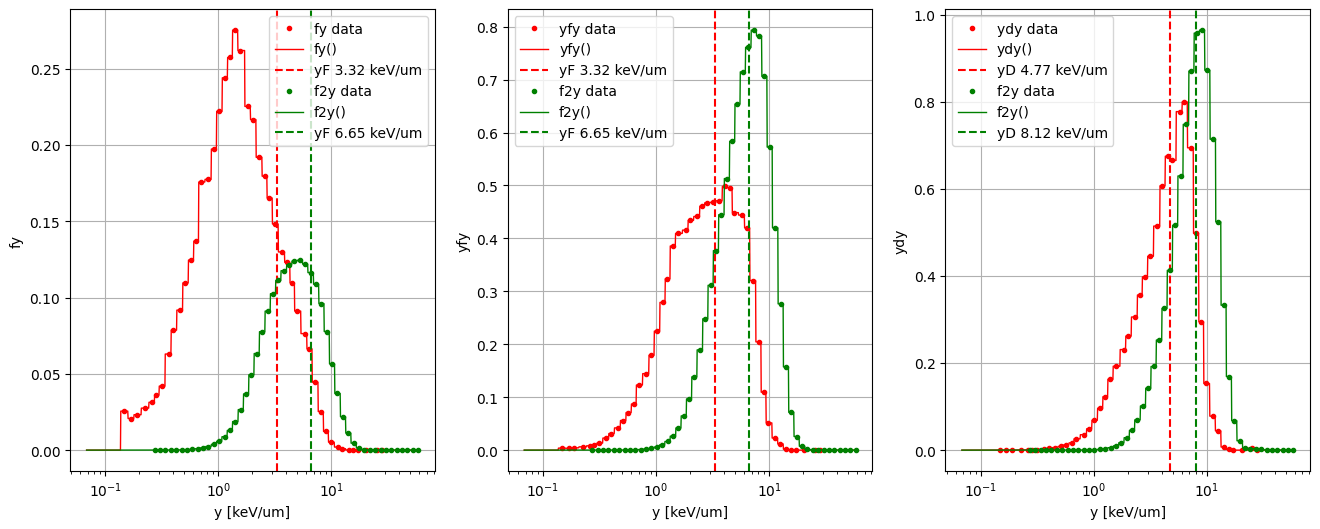

In [79]:
xvalues = np.geomspace(start=spectrum_clipped.bin_edges[0]/2, stop=spectrum_clipped.bin_edges[-1]*2, num=1000)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, '.', label='fy data', color='r')
ax[0].plot(xvalues, spectrum_clipped.bin_values(xvalues, spectrum_value_type=SpectrumValueType.fy), label='fy()', linestyle='-', linewidth=1, color='r')
ax[0].axvline(spectrum_clipped.yF, color='r', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[0].plot(f2_spectrum.y, f2_spectrum.fy, '.', label='f2y data', color='g')
ax[0].plot(xvalues, f2_spectrum.bin_values(xvalues, spectrum_value_type=SpectrumValueType.fy), label='f2y()', linestyle='-', linewidth=1, color='g')
ax[0].axvline(f2_spectrum.yF, color='g', linestyle='--', label=f'yF {f2_spectrum.yF:2.2f} keV/um')
ax[0].set_ylabel('fy')
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, '.', label='yfy data', color='r')
ax[1].plot(xvalues, spectrum_clipped.bin_values(xvalues, spectrum_value_type=SpectrumValueType.yfy), label='yfy()', linestyle='-', linewidth=1, color='r')
ax[1].axvline(spectrum_clipped.yF, color='r', linestyle='--', label=f'yF {spectrum_clipped.yF:2.2f} keV/um')
ax[1].plot(f2_spectrum.y, f2_spectrum.yfy, '.', label='f2y data', color='g')
ax[1].plot(xvalues, f2_spectrum.bin_values(xvalues, spectrum_value_type=SpectrumValueType.yfy), label='f2y()', linestyle='-', linewidth=1, color='g')
ax[1].axvline(f2_spectrum.yF, color='g', linestyle='--', label=f'yF {f2_spectrum.yF:2.2f} keV/um')
ax[1].set_ylabel('yfy')
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, '.', label='ydy data', color='r')
ax[2].plot(xvalues, spectrum_clipped.bin_values(xvalues, spectrum_value_type=SpectrumValueType.ydy), label='ydy()', linestyle='-', linewidth=1, color='r')
ax[2].axvline(spectrum_clipped.yD, color='r', linestyle='--', label=f'yD {spectrum_clipped.yD:2.2f} keV/um')
ax[2].plot(f2_spectrum.y, f2_spectrum.ydy, '.', label='f2y data', color='g')
ax[2].plot(xvalues, f2_spectrum.bin_values(xvalues, spectrum_value_type=SpectrumValueType.ydy), label='f2y()', linestyle='-', linewidth=1, color='g')
ax[2].axvline(f2_spectrum.yD, color='g', linestyle='--', label=f'yD {f2_spectrum.yD:2.2f} keV/um')
ax[2].set_ylabel('ydy')
for a in ax:
    a.set_xscale('log')
    #a.set_yscale('log')
    a.grid()
    a.set_xlabel('y [keV/um]')
    a.legend()